In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
import os

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(1234)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

#pysindy_path = r'C:\Users\phili\PycharmProjects\pysindy'

# Solution of KDV: $u(t,x)=\frac{c}{2}\cosh(\frac{\sqrt{c}}{2}(x-ct))^{-2}$
We have here that $u$ solves the one-way wave equation $u_t = -c u_x$ and the KDV equation $u_t= 6uu_x-u_{xxx}$. This time, we will add gaussian noise with standard deviation of $0.01|u|$.

In [6]:
c = 1
nx, nt = (300, 200)
x = np.linspace(0, 10, nx)
t = np.linspace(0, 10, nt)
tv, xv = np.meshgrid(t, x)

u = c/2*np.cosh(np.sqrt(c)/2*(xv-c*tv))**(-2)
u += np.random.normal(scale=np.abs(u)*0.00001, size=u.shape)

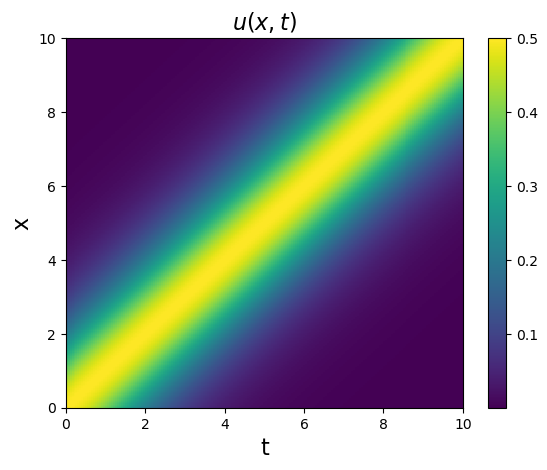

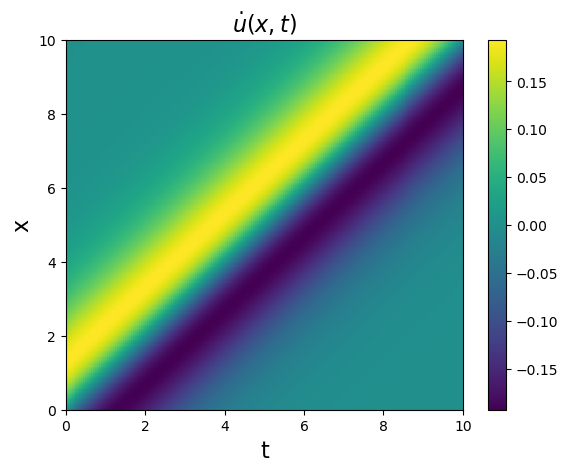

In [7]:
# Plot u and u_dot
plt.figure()
plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.colorbar()
plt.figure()

dt = t[1] - t[0]
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

plt.pcolormesh(t, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$\dot{u}(x, t)$', fontsize=16)

plt.colorbar()
plt.show()

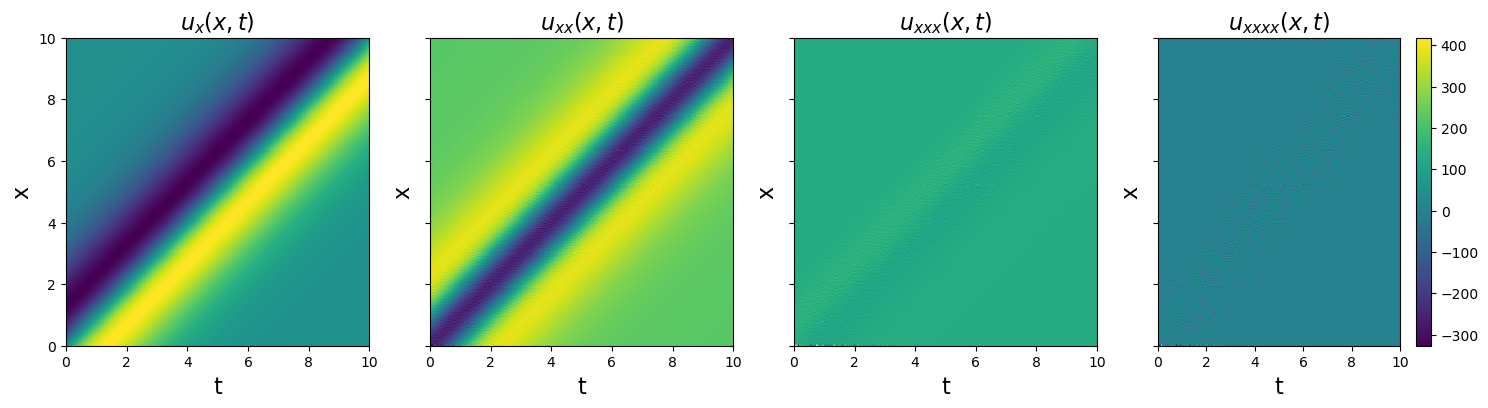

In [8]:
dx = x[1] - x[0]
ux = ps.FiniteDifference(d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0,
                          drop_endpoints=False)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0,
                           drop_endpoints=False)._differentiate(u, dx)
uxxxx = ps.FiniteDifference(d=4, axis=0,
                            drop_endpoints=False)._differentiate(u, dx)

# Plot derivative results
plt.figure(figsize=(18, 4))
plt.subplot(1, 4, 1)
plt.pcolormesh(t, x, ux)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u_x(x, t)$', fontsize=16)
plt.subplot(1, 4, 2)
plt.pcolormesh(t, x, uxx)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 3)
plt.pcolormesh(t, x, uxxx)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxx}(x, t)$', fontsize=16)
plt.subplot(1, 4, 4)
plt.pcolormesh(t, x, uxxxx)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$u_{xxxx}(x, t)$', fontsize=16)
plt.colorbar()
plt.show()

In [9]:
u = u.reshape(len(x), len(t), 1)

# Define PDE library that is quadratic in u, and
# third-order in spatial derivatives of u.
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=3, spatial_grid=x,
                        include_bias=True, is_uniform=True)

# Fit the model with different optimizers.
# Using normalize_columns = True to improve performance.
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=5, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(threshold=7, max_iter=10000, tol=1e-15, nu=1e2,
                   thresholder='l0', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(threshold=0.05, max_iter=10000, tol=1e-15,
                   thresholder='l1', normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, kappa=5e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-5)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = -1.000 x0_1
SR3 model, L0 norm: 
(x0)' = -1.000 x0_1
SR3 model, L1 norm: 
(x0)' = -1.000 x0_1
SSR model: 
(x0)' = -1.000 x0_1 + 0.001 x0x0_1
SSR (metric = model residual) model: 
(x0)' = -1.000 x0_1
FROLs model: 
(x0)' = -1.000 x0_1


So, we clearly see that all models find the the one-way wave equation instead of the KDV equation as it is easier, and none outpouts any warning.
## Check now numerically that we have ambiguity problems

We already know $u$ is not an algebraic function, so we have to check the rank of the feature matrix constructed out of $u$, $u_x$, $u_{xx}$, $u_{xxx}$ and their monomials up to degree 3.

In [10]:
from numpy.linalg import matrix_rank, svd
from itertools import product

In [11]:
def monomials(features, order):
    multi_indices = []
    indices = np.arange(order + 1)
    number_features = features.shape[0]
    repeat_indices = [indices for i in range(number_features)]
    for i in product(*repeat_indices):
        if sum(i) <= order:
            multi_indices += [i]
    new_features = []
    for multi_index in multi_indices:
        new_feature = 1
        for i, j in enumerate(multi_index):
            new_feature *= features[i]**j
        new_features.append(new_feature.reshape(1,-1))
    return np.concatenate(new_features,axis=0)

In [12]:
fd_order = 6
ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)
uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0,
                          drop_endpoints=False)._differentiate(u, dx)
uxxx = ps.FiniteDifference(order=fd_order, d=3, axis=0,
                           drop_endpoints=False)._differentiate(u, dx)

u_flat, u_x_flat, u_xx_flat, u_xxx_flat = u.flatten(), ux.flatten(), uxx.flatten(), uxxx.flatten()

In [13]:
base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1), u_xx_flat.reshape(len(u_flat),-1), u_xxx_flat.reshape(len(u_flat),-1)], axis=1).T 
base_features.shape

(4, 60000)

In [14]:
library = monomials(base_features, order=2)
library.shape

(15, 60000)

In [15]:
matrix_rank(library), svd(library, compute_uv=False)

(15,
 array([2.67505650e+04, 3.87243482e+02, 2.49134595e+02, 1.63723621e+02,
        5.09296120e+01, 4.10250540e+01, 3.97019050e+01, 2.68797788e+01,
        1.56060257e+01, 3.52100423e+00, 2.80838099e+00, 9.09907843e-01,
        8.82123705e-01, 5.88890252e-01, 1.39214175e-01]))

## Singular value ratio plots
Interestingly, one can easily realize the pattern by looking at the ratio between the highest and lowest singular value. For the case that linear dependence exists, we see an exponential growth here with repect to an increasing order of the finite differences method.

### Polynomials of order 1
As $u$ and its derivatives are not linear dependent, we should not see a exponential growth here.

In [16]:
polynomial_order = 1
distance_svs = []
fd_orders = range(2, 10)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)
    uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0,
                              drop_endpoints=False)._differentiate(u, dx)
    uxxx = ps.FiniteDifference(order=fd_order, d=3, axis=0,
                               drop_endpoints=False)._differentiate(u, dx)

    u_flat, u_x_flat, u_xx_flat, u_xxx_flat = u.flatten(), ux.flatten(), uxx.flatten(), uxxx.flatten()
    base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1), u_xx_flat.reshape(len(u_flat),-1), u_xxx_flat.reshape(len(u_flat),-1)], axis=1).T 
    svs = svd(base_features, compute_uv=False)
    distance_svs.append(svs[0] / svs[-1])

In [17]:
svs

array([2847.42094346,   61.96475972,   25.82150589,   23.11450098])

In [291]:
np.max(uxxx)

0.2553678433067148

In [292]:
fd_order

9

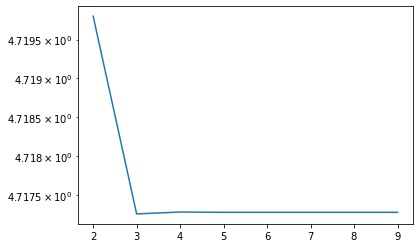

In [293]:
plt.plot(range(2, 10), distance_svs)
plt.yscale('log')

In [294]:
polynomial_order = 1
distance_svs = []
fd_orders = range(2, 10)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)
    uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0,
                              drop_endpoints=False)._differentiate(u, dx)
    uxxx = ps.FiniteDifference(order=fd_order, d=3, axis=0,
                               drop_endpoints=False)._differentiate(u, dx)

    u_flat, u_x_flat, u_xx_flat, u_xxx_flat = u.flatten(), ux.flatten(), uxx.flatten(), uxxx.flatten()
    base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1), u_xx_flat.reshape(len(u_flat),-1), u_xxx_flat.reshape(len(u_flat),-1)], axis=1).T 
    library = monomials(base_features, order=polynomial_order)
    svs = svd(library, compute_uv=False)
    distance_svs.append(svs[0] / svs[-1])

In [295]:
svs

array([248.66026039,  45.97374549,  34.80027749,  14.32202461,
        13.12358369])

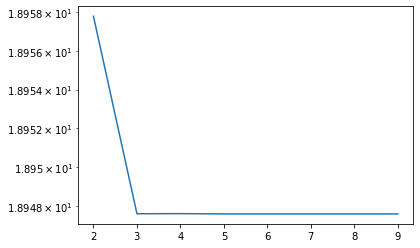

In [296]:
plt.plot(range(2, 10), distance_svs)
plt.yscale('log')

In [297]:
polynomial_order = 1
distance_svs = []
fd_orders = range(2, 10)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)
    uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0,
                              drop_endpoints=False)._differentiate(u, dx)

    u_flat, u_x_flat, u_xx_flat = u.flatten(), ux.flatten(), uxx.flatten()
    base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1), u_xx_flat.reshape(len(u_flat),-1)], axis=1).T 
    library = monomials(base_features, order=polynomial_order)
    svs = svd(library, compute_uv=False)
    distance_svs.append(svs[0] / svs[-1])

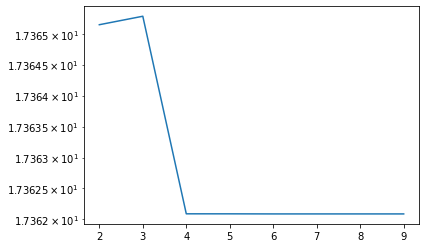

In [298]:
plt.plot(range(2, 10), distance_svs)
plt.yscale('log')

In [299]:
polynomial_order = 1
distance_svs = []
fd_orders = range(2, 10)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)
    
    u_flat, u_x_flat = u.flatten(), ux.flatten()
    base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1)], axis=1).T 
    library = monomials(base_features, order=polynomial_order)
    svs = svd(library, compute_uv=False)
    distance_svs.append(svs[0] / svs[-1])

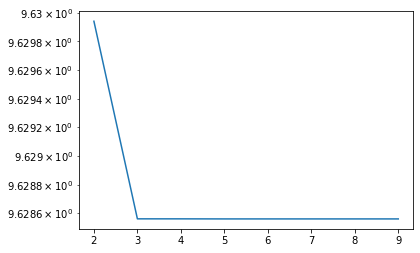

In [300]:
plt.plot(range(2, 10), distance_svs)
plt.yscale('log')

Weirdly we do see exponential growth here... But way smaller. How can we interpret this? Also compare this 

### Polynomials of order 2
As $u$ and its derivatives are algebraically dependent with minimal polynom of degree 2, we expect an exponential growth here.

In [301]:
polynomial_order = 2
distance_svs = []
fd_orders = range(2,10)
for fd_order in fd_orders:
    ux = ps.FiniteDifference(order=fd_order, d=1, axis=0,
                         drop_endpoints=False)._differentiate(u, dx)
    uxx = ps.FiniteDifference(order=fd_order, d=2, axis=0,
                              drop_endpoints=False)._differentiate(u, dx)
    uxxx = ps.FiniteDifference(order=fd_order, d=3, axis=0,
                               drop_endpoints=False)._differentiate(u, dx)

    u_flat, u_x_flat, u_xx_flat, u_xxx_flat = u.flatten(), ux.flatten(), uxx.flatten(), uxxx.flatten()
    base_features = np.concatenate([u_flat.reshape(len(u_flat),-1), u_x_flat.reshape(len(u_flat),-1), u_xx_flat.reshape(len(u_flat),-1), u_xxx_flat.reshape(len(u_flat),-1)], axis=1).T 
    library = monomials(base_features, order=polynomial_order)
    svs = svd(library, compute_uv=False)
    distance_svs.append(svs[0] / svs[-1])

In [302]:
svs

array([2.49222632e+02, 5.10112463e+01, 3.72143935e+01, 1.56119162e+01,
       1.37560543e+01, 4.73414842e+00, 2.96792099e+00, 1.39655449e+00,
       5.80044505e-01, 2.74382223e-01, 1.31682115e-08, 5.29852685e-09,
       3.40399169e-09, 6.89060001e-11, 2.05945347e-11])

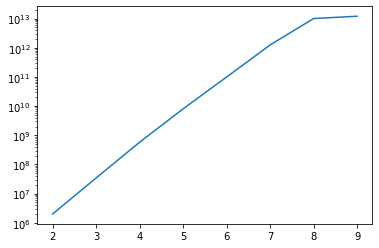

In [303]:
plt.plot(range(2,10), distance_svs)
plt.yscale('log')

## Let us see what the Jacobi criterion would give us in this case
Actually nothing interesting as the Jacobi criterion only works if there are more variables than functions, but here we are looking at at least 4 different functions $u$, $u_x$, $u_{xx}$ and $u_{xxx}$ and only 2 variables $t$ and $x$.